In [1]:
from alntk.alignment import import_from_fasta, get_unaligned_seqs, get_compact_alignment, write_to_fasta
from alntk.plotting import default_plot_style

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
color_cycle = default_plot_style()
data_folder = '../data/'

# Subsampling

Now we can proceed to the compactification of our alignment. However performing these operations on the entire alignment may be resource heavy: we can perform the analysis on a subsample (i.e. ~10^4 sequences instead of ~10^5).

In [4]:
new_aln_descs, new_aln_seqs = import_from_fasta(data_folder + 'new_aln.faa')

In [5]:
# Let us set a fixed seed for reproducibility
np.random.seed(42)

In [6]:
subsample_mask = np.random.randint(0, len(new_aln_descs), size=10_000)

In [7]:
subaln_seqs = new_aln_seqs[subsample_mask]
subaln_descs = new_aln_descs[subsample_mask]

# Compactifying the alignment

## Example: choose the threshold at one value (95%)

We might look at the scatterplot of counts of gaps and select a certain threshold. We might keep sequences that have a gap in positions that are above threshold, meaning that most of these sequences have these gap stretches in common.

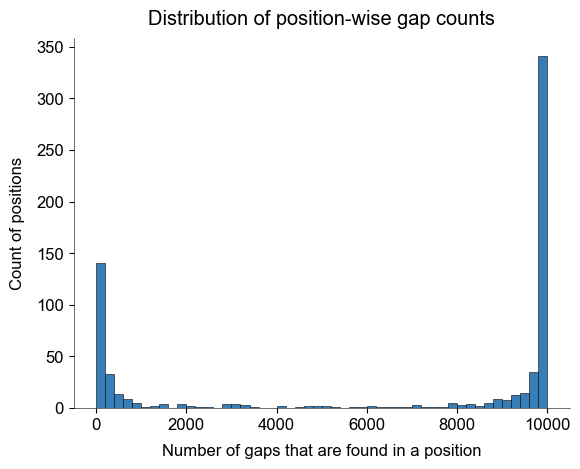

In [8]:
plt.figure()
plt.title('Distribution of position-wise gap counts')
plt.xlabel('Number of gaps that are found in a position')
plt.ylabel('Count of positions')
plt.hist(np.sum(subaln_seqs == '-', axis=0), bins=50)
plt.show()

The histogram reads as follows. If we count the number of gaps in each column we get:

- many positions that have a really low number of gaps
- few positions that have an "intermediate" number of gaps
- many positions that have a really high number of gaps

Our line of reasoning is that we can get rid of the highly gappy positions by choosing a threshold, and throwing away all the sequences that have amino acids in positions that are gappy. This means that we are removing sequences with "rare" amino acids.

If a lot of the gaps are in common, this means that these residues are less relevant. Let us then find these residues by setting a cutoff at, say, 95% of gaps.

In [9]:
gap_threshold_ratio = 0.95
gap_threshold = int(gap_threshold_ratio*subaln_seqs.shape[0])

# make a matrix of boolean value according to whether it is a gap or not
aln_seqs_isgap = (subaln_seqs == '-')

# count the number of gaps column wise
gaps_per_column = np.sum(aln_seqs_isgap, axis=0)

# where are the positions in which there are a lot of gaps?
gappy_positions = np.where(gaps_per_column > gap_threshold)[0]

# select the gappy positions of sequences and check the amino acids that are there
# if we sum over the rows, we get the number of "amino acids in unusual positions" per sequence
unusual_aa_per_sequence = np.sum(subaln_seqs[:, gappy_positions] != '-', axis=1)

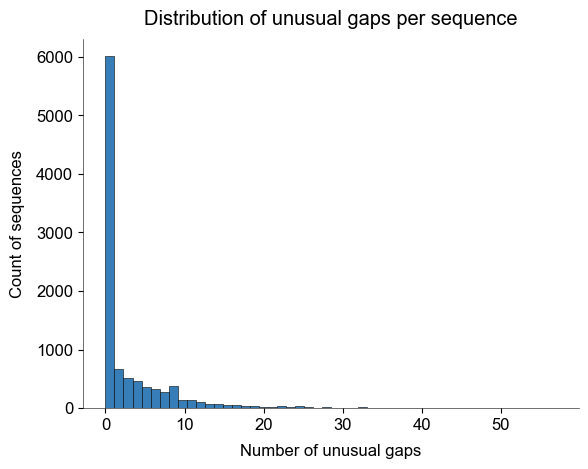

In [10]:
plt.figure()
plt.title('Distribution of unusual gaps per sequence')
plt.xlabel('Number of unusual gaps')
plt.ylabel('Count of sequences')
plt.hist(unusual_aa_per_sequence, bins=50)
plt.show()

In [11]:
# let us keep retain just the sequences that have ZERO unusual aa's
sequences_mask = np.where(unusual_aa_per_sequence == 0)[0]
# this will be our mask for the sequences that have ZERO unusual aa's
post_cutoff_subaln_seqs = subaln_seqs[sequences_mask, :]

In [12]:
post_cutoff_subaln_seqs.shape

(4864, 693)

We can now get rid of the fully gapped columns.

In [13]:
post_cutoff_subaln_seqs_isaa = (post_cutoff_subaln_seqs != '-')
new_aa_per_column = np.sum(post_cutoff_subaln_seqs_isaa, axis=0)

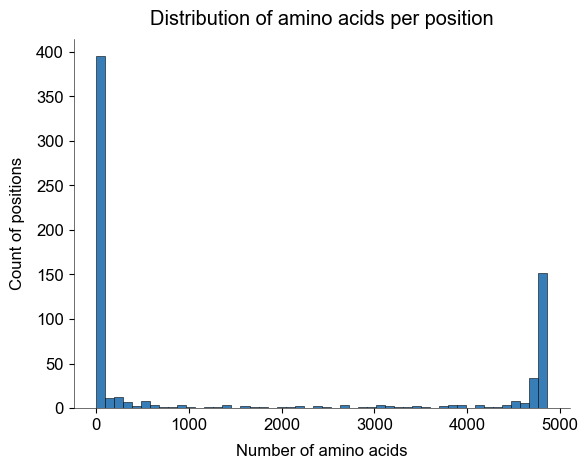

In [14]:
plt.figure()
plt.title('Distribution of amino acids per position')
plt.xlabel('Number of amino acids')
plt.ylabel('Count of positions')
plt.hist(new_aa_per_column, bins=50)
plt.show()

In [15]:
# if there are 0 aa per column, then discard the position
position_mask = np.where(new_aa_per_column > 0)[0]

post_cutoff_subaln_seqs = post_cutoff_subaln_seqs[:, position_mask]

post_cutoff_subaln_seqs.shape

(4864, 307)

What's the maximum number of gaps in any column for a given threshold?

In [16]:
np.max(np.sum(post_cutoff_subaln_seqs == '-', axis=0))

4848

We can see that in this new alignment we could suppress all those zero valued positions. For example:

In [17]:
for chunk in range(post_cutoff_subaln_seqs.shape[1] // 100):
    for i, seq in enumerate(post_cutoff_subaln_seqs):
        print(''.join(seq)[chunk*100:(chunk+1)*100])
        if i==5: break
    print('')
for i, seq in enumerate(post_cutoff_subaln_seqs):
    print(''.join(seq)[(chunk+1)*100:])
    if i==5: break
print('')

ITNGYPAYEGKAPYAVGLSF--------NGWWCGGSIIAHDWVLTAAHCTNG----------ASSVTIYYGATWRTN--AQFTHTVGSGDRNDIINH---
VVNGKNAQEGAWPWMASIQWR-------GTHFCGASLISSRWLLSAAHCFVKKTS-------LKDWTVNFGL--------VVNKPYITHKVRRIILHEHF
VVGGEPAEEGEFPFMMRLTIG-------GQDACGASLIRPDVALTAAHCTDGS----------EGFTVKYGTNKLD------DPEIKEIKVTEVTQNPDF
IIGGEFTTIENQPWFAAIYRRHH--GGSITYLCGGSLISPCWVLSATHCFINHPK-------KEDYIVYLGRSKRN----SGTPGEMMFEVEKLILHEDY
VVGGKAAKFGEWPWQVLVRESTWL-GLFTKNKCGGVLITNEYVVTAAHCQPGF---------LASLVAVFGEFDISS--DLETKRSVTKNVKRVIVHRQY
IVGGFSAASGEVPWQVSLKEG-------SRHFCGATVVGDRWLLSAAHCFNHTK--------VELVRAHLGTASLS----GISGSPVKMGLRRAVLHPQY

-------HNADIALIRIPH-VDFW----HMVNKV--ELPSYN-DRYNDFNE-RWAVACGWGG-T-----YDG-SPLPDWLQCVDLQIIHNSECQRTYGS-
KS---AGVHNDIALVELANEVSFT----KYIRKIC--LPEAS---MKLSEQ-DKVVVTGWGA-LS----MNG--PRPVILQEAPLKIIDNEICNAPHVL-
GK--PIEMAGDWSVLKLEAPA-------EGVEPVK--LAEDD----S--VDLEEQTIMGWGA-TS----EGG--EQSNELLKAKVPGVDDEKCKEAYGE-
NA-DNLAHHNDIALLKIRSNTGQCAQPSRSIQTIC--LPPVR---GDANFG-MSCEIAGFGK-END---TD--YLYPEQLKMTVVKLVSY

## Systematically compactification per threshold

We can now study how we can get different performances by changing the threshold.

In [18]:
def get_aln_stats(gap_threshold_ratio, aln_descs=subaln_descs, aln_seqs=subaln_seqs):
    final_aln_descs, final_aln_seqs = get_compact_alignment(aln_descs, aln_seqs, gap_threshold_ratio)
    newaln_shape = final_aln_seqs.shape
    
    removed_descs = set(aln_descs) - set(final_aln_descs)
    sp_included_count, sp_removed_count = 0, 0
    for aln_desc in final_aln_descs:
        db_signature = aln_desc.split('|')[0]
        if db_signature == 'sp':
            sp_included_count += 1
    for removed_desc in removed_descs:
        db_signature = removed_desc.split('|')[0]
        if db_signature == 'sp':
            sp_removed_count += 1
    try:
        maxgap_in_cols = np.max(np.sum(final_aln_seqs == '-', axis=0))
        maxgap_in_rows = np.max(np.sum(final_aln_seqs == '-', axis=1))
    except:
        maxgap_in_cols, maxgap_in_rows = 0, 0

    # return n_seq, n_pos, n_sp_in, n_sp_out
    return *newaln_shape, sp_included_count, sp_removed_count, maxgap_in_cols, maxgap_in_rows

In [19]:
xvalues = np.array([0., 0.1, 0.2, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 1.])
aln_stats = []
for xvalue in xvalues:
    aln_stats.append(get_aln_stats(xvalue))
aln_stats = np.array(aln_stats)

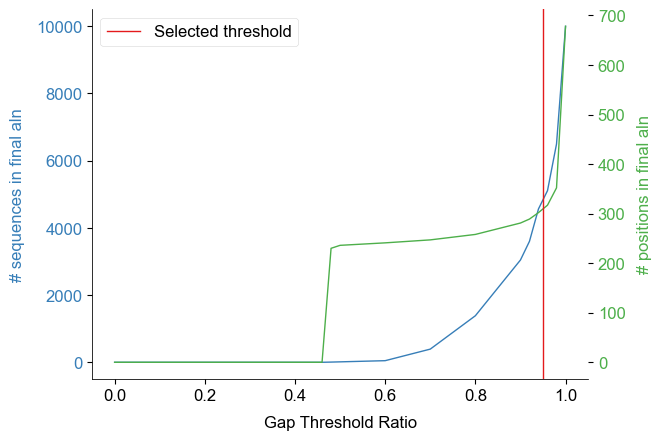

In [20]:
fig, ax1 = plt.subplots()
ax1.plot(xvalues, aln_stats[:, 0], color='#'+color_cycle[0])
ax2 = ax1.twinx()
ax2.plot(xvalues, aln_stats[:, 1], color='#'+color_cycle[2])
plt.axvline(x=0.95, color='#'+color_cycle[1], label='Selected threshold')
ax1.set_xlabel('Gap Threshold Ratio')
ax1.set_ylabel('# sequences in final aln', color='#'+color_cycle[0])
ax2.set_ylabel('# positions in final aln', color='#'+color_cycle[2])
ax1.tick_params(axis='y', labelcolor='#'+color_cycle[0])
ax2.tick_params(axis='y', labelcolor='#'+color_cycle[2])
plt.legend()
plt.show()

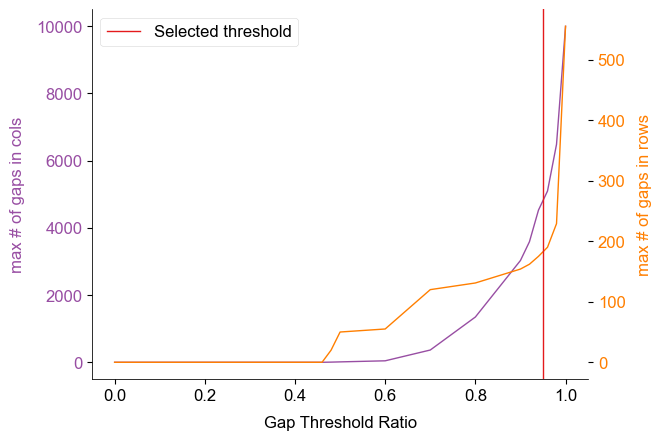

In [21]:
fig, ax1 = plt.subplots()
ax1.plot(xvalues, aln_stats[:, 4], color='#'+color_cycle[3])
ax2 = ax1.twinx()
ax2.plot(xvalues, aln_stats[:, 5], color='#'+color_cycle[4])
plt.axvline(x=0.95, color='#'+color_cycle[1], label='Selected threshold')
ax1.set_xlabel('Gap Threshold Ratio')
ax1.set_ylabel('max # of gaps in cols', color='#'+color_cycle[3])
ax2.set_ylabel('max # of gaps in rows', color='#'+color_cycle[4])
ax1.tick_params(axis='y', labelcolor='#'+color_cycle[3])
ax2.tick_params(axis='y', labelcolor='#'+color_cycle[4])
plt.legend()
plt.show()

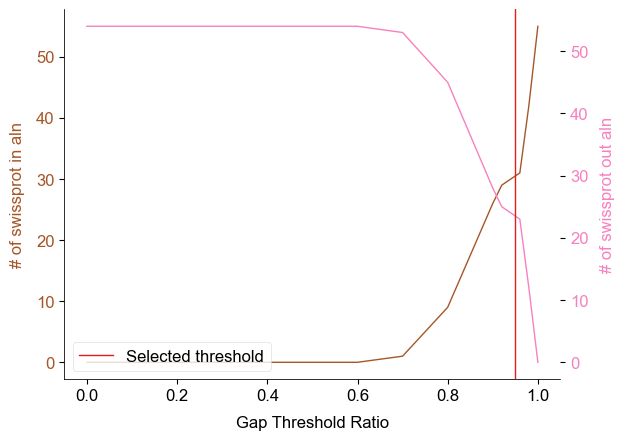

In [22]:
fig, ax1 = plt.subplots()
ax1.plot(xvalues, aln_stats[:, 2], color='#'+color_cycle[6])
ax2 = ax1.twinx()
ax2.plot(xvalues, aln_stats[:, 3], color='#'+color_cycle[7])
plt.axvline(x=0.95, color='#'+color_cycle[1], label='Selected threshold')
ax1.set_xlabel('Gap Threshold Ratio')
ax1.set_ylabel('# of swissprot in aln', color='#'+color_cycle[6])
ax2.set_ylabel('# of swissprot out aln', color='#'+color_cycle[7])
ax1.tick_params(axis='y', labelcolor='#'+color_cycle[6])
ax2.tick_params(axis='y', labelcolor='#'+color_cycle[7])
plt.legend()
plt.show()

# Distribution of sequences depending on threshold

We can study the dependency of the distribution in sequence space as the threshold changes, to see whether there are parts of the space that are neglected or if the sampling is uniform.

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

In [24]:
ohe = OneHotEncoder(handle_unknown='ignore')
s_ohe = ohe.fit_transform(subaln_seqs)
pca = PCA(n_components=2, svd_solver='arpack')
pca.fit(s_ohe)
s_pca = pca.transform(s_ohe)

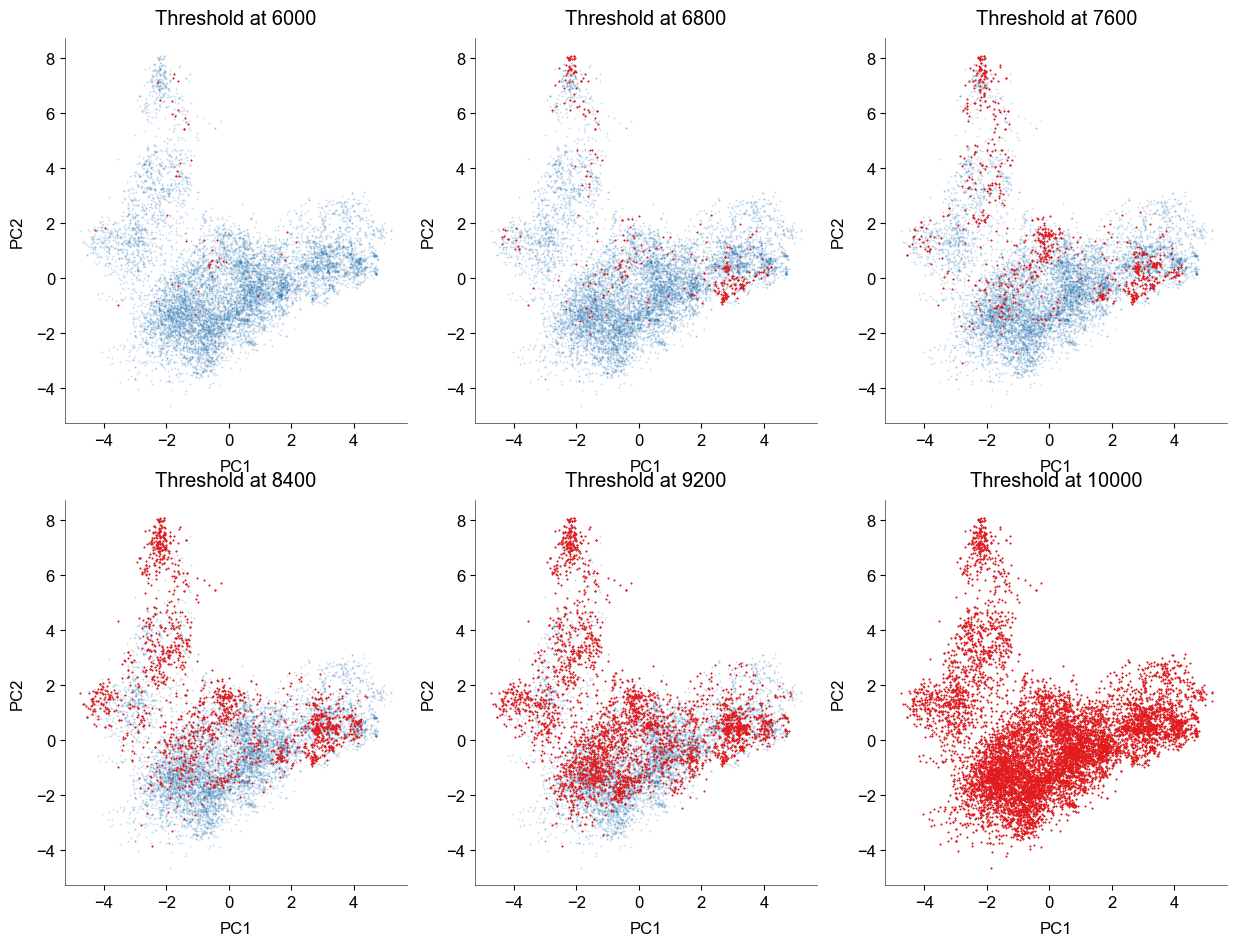

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15,11))
for i, gap_thr in enumerate(np.linspace(6000, 10_000, 6)):
    gappy_pos = np.where(np.sum(subaln_seqs == '-', axis=0) > gap_thr)[0]
    mask = np.where(np.sum((subaln_seqs != '-')[:, gappy_pos], axis=1) == 0)[0]
    new_subaln_seqs = subaln_seqs[mask]
    new_subaln_seqs_pca = pca.transform(ohe.transform(new_subaln_seqs))
    axs[i//3][i%3].scatter(s_pca[:, 0], s_pca[:, 1], s=1, alpha=0.2)
    axs[i//3][i%3].scatter(new_subaln_seqs_pca[:, 0], new_subaln_seqs_pca[:, 1], s=1, alpha=1)
    axs[i//3][i%3].title.set_text(f'Threshold at {round(gap_thr)}')
    axs[i//3][i%3].set_xlabel('PC1')
    axs[i//3][i%3].set_ylabel('PC2')
plt.show()

# Choose a threshold and compactify the entire alignment

Now that we have understood the virtues and drawbacks of the compactification, let us choose a threshold and apply that to the entire alignment.